In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from matplotlib import pyplot as plt
filename = "hotel_bookings.csv"
file_path = os.path.join("..","data",filename)
df = pd.read_csv(file_path)

## 2.1 Cramer's V for categorical features

 Cramer's V model based on the chi squared satistic that can show how strongly nominal variables are associated with one another.

In [2]:
df=df.drop('reservation_status',axis=1)

In [3]:
df['is_canceled']=df['is_canceled'].replace([0,1],["no","yes"])

In [4]:
cols = df.columns
num_cols = df._get_numeric_data().columns
cat_cols=list(set(cols) - set(num_cols))

In [5]:
df_cat=df[cat_cols]

In [6]:
df_cat.columns

Index(['market_segment', 'assigned_room_type', 'meal', 'reserved_room_type',
       'distribution_channel', 'hotel', 'is_canceled', 'deposit_type',
       'arrival_date_month', 'reservation_status_date', 'country',
       'customer_type'],
      dtype='object')

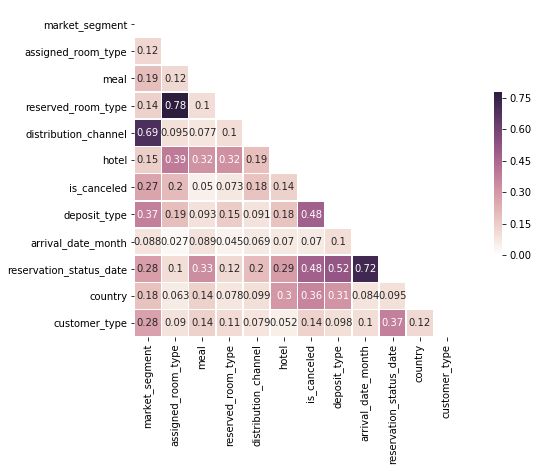

In [7]:
import itertools
import scipy
def cramers_corrected_stat(confusion_matrix):
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
cols = list(df_cat.columns.values)
emp_arr = np.zeros((len(cols),len(cols)))
for col1, col2 in itertools.combinations(cols, 2):
    A, B = df_cat[col1], df_cat[col2]
    idx1, idx2 = cols.index(col1), cols.index(col2)
    conf_mat = pd.crosstab(A,B) 
    #appending results to emp_array
    emp_arr[idx1, idx2] = cramers_corrected_stat(conf_mat.values)
    emp_arr[idx2, idx1] = emp_arr[idx1, idx2]
corr = pd.DataFrame(emp_arr, index=cols, columns=cols)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(12, 6))
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

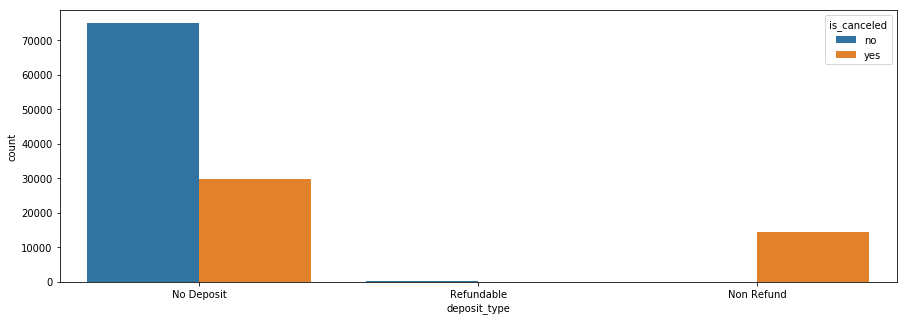

In [8]:
plt.figure(figsize=(15,5))
sns.countplot(x='deposit_type',data=df,hue='is_canceled')

## 2.2 Correlation for numerical features

In [9]:
df['is_canceled']=df['is_canceled'].replace(["no","yes"],[0,1])

In [10]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,2015-07-03


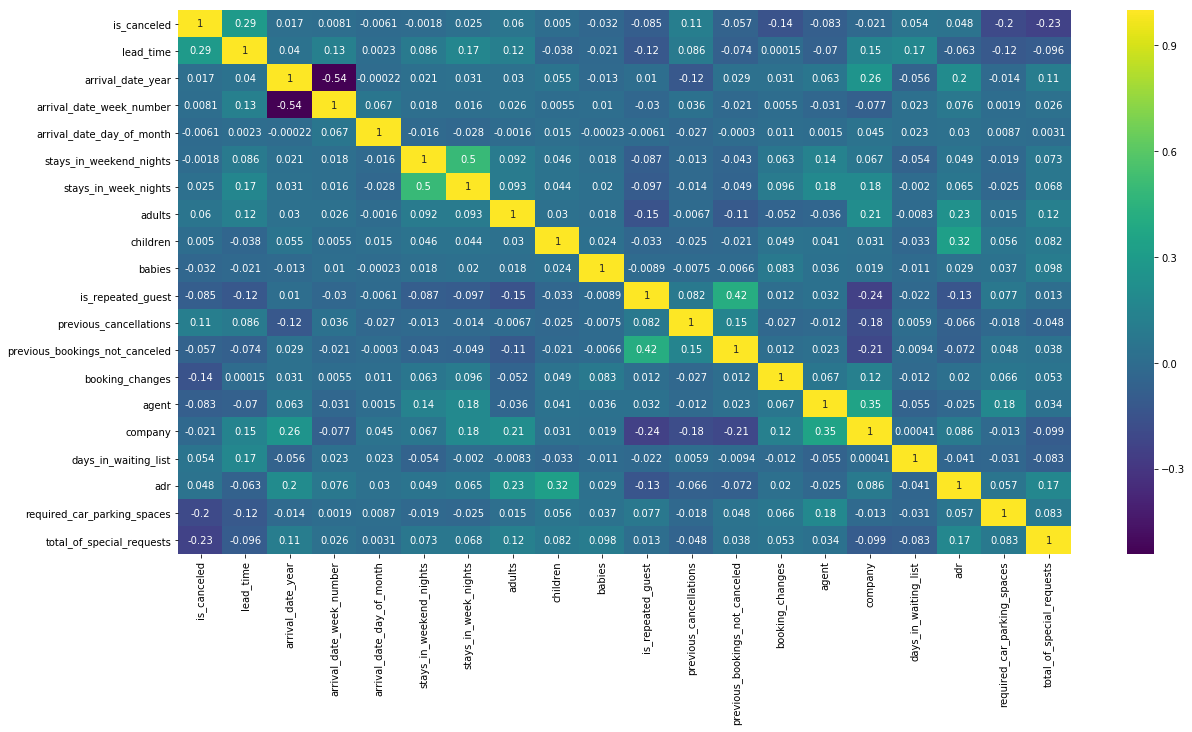

In [11]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True,cmap='viridis')

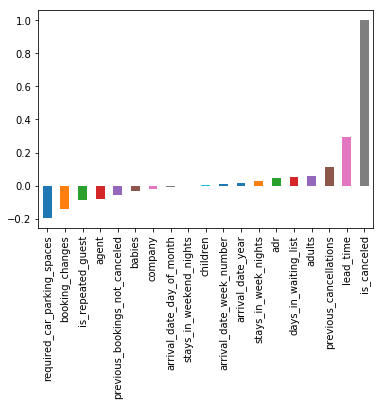

In [12]:
df.corr()['is_canceled'][:-1].sort_values().plot(kind='bar')

# 3. Dimensionality reduction : PCA 

## 3.1 Categorical features only

In [13]:
X_cat = df_cat.drop("is_canceled", axis=1)
y_cat = df_cat["is_canceled"].eq('yes').mul(1)

In [14]:
X_cat.head()

,market_segment,assigned_room_type,meal,reserved_room_type,distribution_channel,hotel,deposit_type,arrival_date_month,reservation_status_date,country,customer_type
0,Direct,C,BB,C,Direct,Resort Hotel,No Deposit,July,2015-07-01,PRT,Transient
1,Direct,C,BB,C,Direct,Resort Hotel,No Deposit,July,2015-07-01,PRT,Transient
2,Direct,C,BB,A,Direct,Resort Hotel,No Deposit,July,2015-07-02,GBR,Transient
3,Corporate,A,BB,A,Corporate,Resort Hotel,No Deposit,July,2015-07-02,GBR,Transient
4,Online TA,A,BB,A,TA/TO,Resort Hotel,No Deposit,July,2015-07-03,GBR,Transient


In [15]:
X_cat['country'].fillna("No Country", inplace = True)

In [16]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def labelencode(df):
    le = LabelEncoder()
    return df.apply(le.fit_transform)

def onehotencode(df):
    onehot = OneHotEncoder()
    return onehot.fit_transform(df).toarray()

X_2 = labelencode(X_cat)
onehotlabels = onehotencode(X_2)

In [17]:
X_2.head().transpose()

,0,1,2,3,4
market_segment,3,3,3,2,6
assigned_room_type,2,2,2,0,0
meal,0,0,0,0,0
reserved_room_type,2,2,0,0,0
distribution_channel,1,1,1,0,3
hotel,1,1,1,1,1
deposit_type,0,0,0,0,0
arrival_date_month,5,5,5,5,5
reservation_status_date,121,121,122,122,123
country,136,136,59,59,59


In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(onehotlabels)

In [19]:
ex_variance=np.var(X_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)

[0.44257446 0.32937114 0.2280544 ]


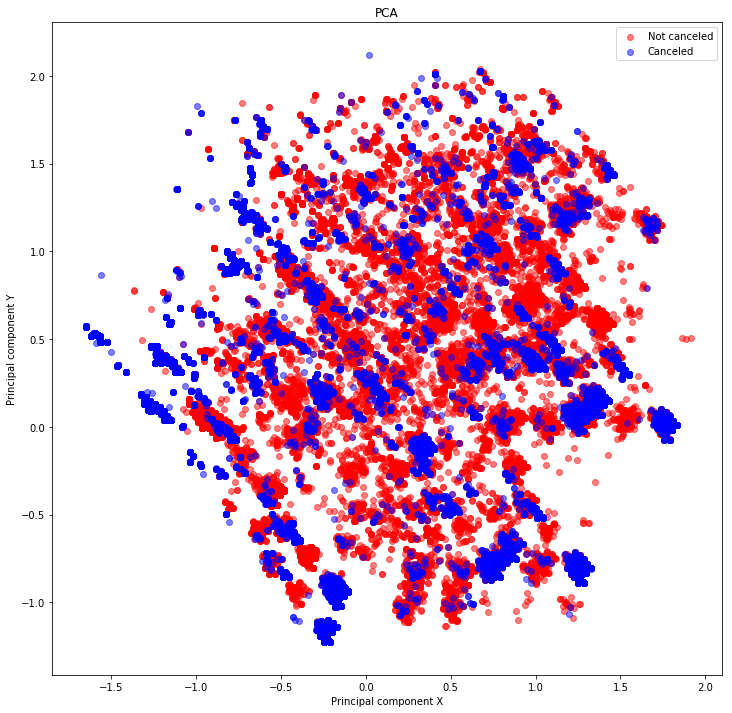

In [20]:
pca = PCA(n_components=len(df_cat.columns))
X_pca = pca.fit_transform(onehotlabels)
X_pca_reconst = pca.inverse_transform(X_pca)
plt.figure(figsize=(12,12))
plt.scatter(X_pca[y_cat==0, 0], X_pca[y_cat==0, 1], color='red', alpha=0.5,label='Not canceled')
plt.scatter(X_pca[y_cat==1, 0], X_pca[y_cat==1, 1], color='blue', alpha=0.5,label='Canceled')
plt.title("PCA")
plt.ylabel('Principal component Y')
plt.xlabel('Principal component X')
plt.legend()
plt.show()

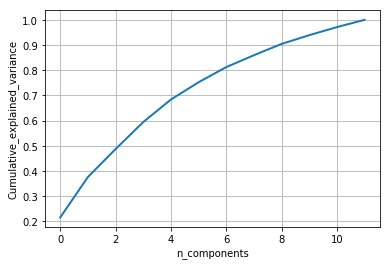

In [21]:
pca = PCA(n_components=len(df_cat.columns))
X_pca = pca.fit_transform(onehotlabels)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()